In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# import the architecture
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np
import pandas as pd

In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
%cd /content/drive/MyDrive/'Colab Notebooks'/
# import our created package
import training_pg as pg
import importlib
# reloading the package if we make any change on it
importlib.reload(pg)
from sklearn.model_selection import train_test_split

/content/drive/MyDrive/Colab Notebooks


## **Why this Block?**
To work on other models or on other Dataset i just copy this notebook and i modify  these variables (modifying ones). So this way I gain time and avoid making errors (forgetting to change in other places)

In [ ]:

tc_algo_folder= "inceptionV3"
#tc_img_dim=(224, 224)
tc_img_dim=(299, 299)

 
# Some setup for trainning 
1.   Defining the number of epochs and batch size
2.   Early stoping and checkpoint to avoid overfitting 




In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

batch_size = 32
epochs = 200
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, verbose=1)

# **Load Data**

In [ ]:
# Here we load data from pickels
X,Y_= pg.get_data(str(tc_img_dim[0]))
Y = to_categorical(Y_)

In [ ]:
X.shape

(4000, 224, 224, 3)

# **Activate the TPU**

In [ ]:
use_tpu = True
import os
if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

# TPU address
tpu_address = TF_MASTER

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)


In [ ]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [ ]:
%cd /content/drive/MyDrive/Breast_Cancer/

/content/drive/MyDrive/Breast_Cancer


## **Training + KFOLD**


1.  First we defind fold_y / fold_y_pred / histories where we store training history 
2.   We use 5fold stratified to avoid overfitting and make sure that the results are good
3. We call the training_pg where we defined the training 
4. Since the training is super fast we can keep checkpoint od delet it (Up to you) Personnly I dont use it / In case you use GPU or CPU checkpoint is mondatory :) 
5. We make sure to delet the x_train y_train x_test y_test and model to liberate the RAM (since everything is saved) 










In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
    
folds_y = []
folds_y_pred = []
histories= []
fold = 0
for train, test in skf.split(X,Y_):
    fold+=1
    print("########################################################################")
    print(f"Fold #{fold}")
    print("########################################################################")
    x_train = X[train]
    y_train = Y[train]
    x_test = X[test]
    y_test = Y[test]
        
    with strategy.scope():
      if tc_algo_folder == "Baseline":
        model = pg.get_baseline()
      else :
        tc_base_cnv= pg.base_conv(tc_algo_folder)
        model = pg.get_model(tc_base_cnv,trainable=False)
      
    checkpoint = ModelCheckpoint( filepath='results/vectors/'+tc_algo_folder+'/fold_'+str(fold)+'.h5', monitor='val_accuracy', save_best_only=True, verbose= 1, save_weights_only=False)
    history= model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=epochs,batch_size = batch_size, callbacks=[reduce_lr,early_stopping, checkpoint])
    del model
    #loading best classifier and save it to my drive
    model= load_model('/content/drive/MyDrive/Breast_Cancer/results/vectors/'+tc_algo_folder+'/fold_'+str(fold)+'.h5')
    pred = model.predict(x_test)
    folds_y.append(y_test)
    folds_y_pred.append(pred)
    histories.append(history.history)
    del model, x_train, y_train, x_test, y_test

########################################################################
Fold #1
########################################################################
19996672/19993432 [==============================] - 0s 0us/step
Epoch 1/200
100/100 [==============================] - 56s 259ms/step - loss: 10.6827 - accuracy: 0.6269 - val_loss: 10.2070 - val_accuracy: 0.7487

Epoch 00001: val_accuracy improved from -inf to 0.74875, saving model to results/vectors/nasNet/fold_1.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
100/100 [==============================] - 6s 56ms/step - loss: 10.0492 - accuracy: 0.7328 - val_loss: 9.8041 - val_accuracy: 0.7337

Epoch 00002: val_accuracy did not improve from 0.74875
Epoch 3/200
100/100 [==============================] - 6s 65ms/step - loss: 9.5886 - accuracy: 0.7653 - val_loss: 9.4023 - val_accuracy: 0.7763

Epoch 00003: val_accuracy improved from 0.74875 to 0.77625, saving model to results/vectors/nasNet/fold_1.h5
Epoch 4/200
100/100 [==============================] - 5s 54ms/step - loss: 9.1696 - accuracy: 0.7994 - val_loss: 9.0380 - val_accuracy: 0.7675

Epoch 00004: val_accuracy did not improve from 0.77625
Epoch 5/200
100/100 [==============================] - 6s 58ms/step - loss: 8.7848 - accuracy: 0.8247 - val_loss: 8.6940 - val_accuracy: 0.7837

Epoch 00005: val_accuracy improved from 0.77625 to 0.78375, saving model to results/vectors/nasNet/fold_1.h5
Epoch 6/200
100/100 [==============================] - 5s 54ms/step - loss: 8.4288 - accura

In [ ]:
## save folds_y folds_y_pred and histories
## (folds_y folds_y_pred) to calcutate metrics (accuracy, recall ...)
## histories_ for ploting accuracy and loss curves
pg.save_folds_vectors(folds_y,  tc_algo_folder, name="folds_y_vf.npy")
pg.save_folds_vectors(folds_y_pred,  tc_algo_folder, name="folds_y_pred_vf.npy")
pg.save_folds_vectors(histories,  tc_algo_folder, name="histories__vf.npy")

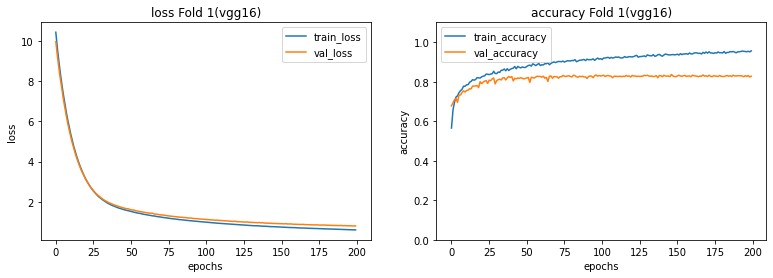

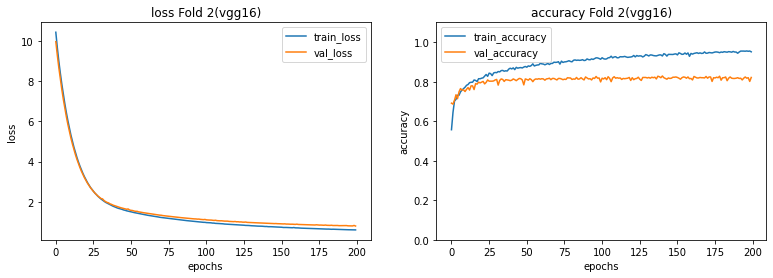

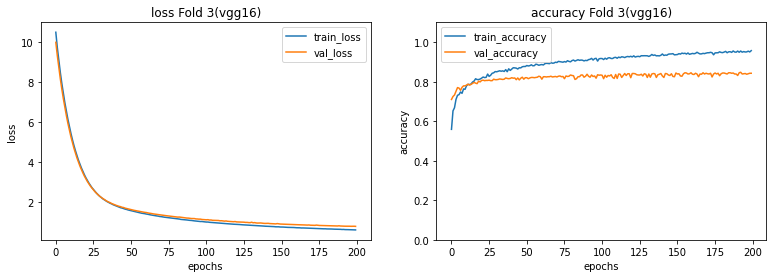

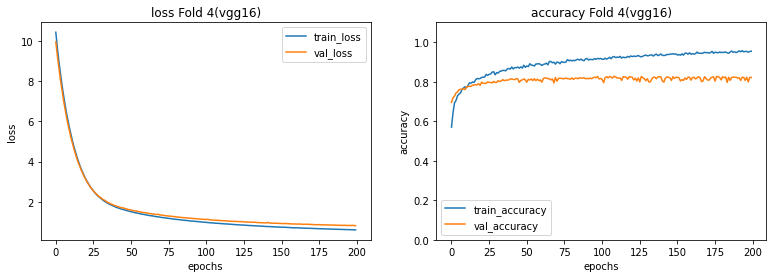

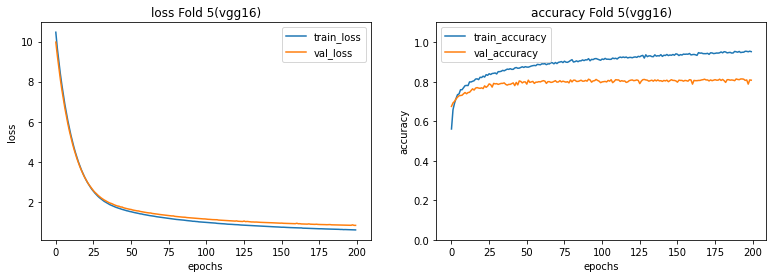

In [ ]:
# ploting folds accuracy and loss curves
for i, histo in enumerate(histories):
 pg.plot_loss_acc(histo, epochs, "Fold "+str(i+1)+"("+tc_algo_folder+")")
 plt.savefig('/content/drive/MyDrive/Breast_Cancer/results/plots/'+tc_algo_folder+'/plt_fold'+str(i+1))